In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
!gdown --id 1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
!gdown --id 1bs8PHTExPfItW636-HVRVYwjjPilQVgy

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
To: /content/id_map.parquet
100% 1.20M/1.20M [00:00<00:00, 76.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
To: /content/train.csv
42.9MB [00:00, 83.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bs8PHTExPfItW636-HVRVYwjjPilQVgy
To: /content/test.csv
24.8MB [00:00, 78.7MB/s]


In [ ]:
!pip install imbalanced-learn
!pip install scikit-learn==0.24
!pip install catboost
!pip install tldextract

     |████████████████████████████████| 22.3 MB 1.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 67.4 MB 75 kB/s 
     |████████████████████████████████| 87 kB 4.2 MB/s 


# Dependencies

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


import time
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier

import re
from wordcloud import WordCloud
from tldextract import extract
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

from imblearn.pipeline import Pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE

# Support

In [ ]:
def func_roc_auc(proba, y):
    sns.set(style="whitegrid", palette='Dark2')
    
    auc = roc_auc_score(np.array(y), np.transpose(proba)[1])
    print(f'Лучшее качество auc_best_estimator: {auc:.3}')
    
    fpr, tpr, _ = roc_curve(y, proba[:,1])
    
    f = plt.figure()
    plt.plot(fpr, tpr, label = 'best_estimator')
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")
    plt.show()

In [ ]:
def cv_curve(param_name, mean_test, std_test, mean_train, std_train, param_val, x_type, param_scale="log"):
    #try:
    #    param_val.sort()
    #except:
    #    pass
    lower_b_tt = mean_test - 2*std_test
    upper_b_tt= mean_test + 2*std_test
    
    lower_b_tn = mean_train - 2*std_train
    upper_b_tn = mean_train + 2*std_train
    
    f = plt.figure(figsize=(13,5))
    plt.title('choose ' + param_name)
    
    if x_type == 'O':
        plt.plot(range(len(param_val)), mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(range(len(param_val)), lower_b_tt, label='test lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tt, label='test upper bound', color='b', lw=2, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)

        plt.plot(range(len(param_val)), mean_train, label='train mean values of score', color='gray', lw=1)
        plt.plot(range(len(param_val)), lower_b_tn, label='train lower bound', color='gray', lw=1, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tn, label='train upper bound', color='gray', lw=1, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)
    else:
        if param_scale =='log':
            plt.xscale('log')
        plt.plot(param_val, mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(param_val, lower_b_t, label='lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(param_val, upper_b_t, label='upper bound', color='b', lw=2, linestyle='dashed')
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('red')
    plt.xlabel('parameter')
    plt.ylabel('roc_auc')
    plt.show()

In [ ]:
def merge_data_and_domain(data, id_map):
    for i in range(1,11):
        data = pd.merge(data, id_map.rename(columns={"id":"webpage"+str(i), "domain":"domain"+str(i)}).loc[:, ["webpage"+str(i), "domain"+str(i)]], on="webpage"+str(i), how="left")

    string = data.loc[:, ["session_id"]+["domain"+str(i) for i in range(1,11)]].fillna("left")
    string["string"] = string.apply(lambda x: " ".join(x.values[1:]), axis=1)
    string.loc[:, "preproc_tokens"] = string.loc[:, "string"].apply(lambda x: x.split(' ')).values
    return string

In [ ]:
def merge_data_and_suf(data, id_map):
    for i in range(1,11):
        data = pd.merge(data, id_map.rename(columns={"id":"webpage"+str(i), "suf":"suf"+str(i)}).loc[:, ["webpage"+str(i), "suf"+str(i)]], on="webpage"+str(i), how="left")

    string = data.loc[:, ["session_id"]+["suf"+str(i) for i in range(1,11)]].fillna("no_data").replace("", "empty")
    return string

In [ ]:
def train_word2vec(train_domain_features, test_domain_features, 
                   size, window, min_count, workers, sg, refit):
    # Store the model in following file
    word2vec_model_file = OUTPUT_FOLDER + '/word2vec_' + str(size) + '.model'
    # Store the vectors for train data in following file
    word2vec_filename = OUTPUT_FOLDER + '/train_review_word2vec.csv'
    if refit:
        start_time = time.time()
        preproc_tokens = pd.Series(train_domain_features['preproc_tokens']).values
        # Train the Word2Vec Model
        w2v_model = Word2Vec(preproc_tokens, min_count=min_count, size=size, workers=workers, window=window, sg=sg)
        print(f"Time taken to train word2vec model: {(time.time() - start_time)/60:0.03} min")
        # save model to file
        w2v_model.save(word2vec_model_file)

        # save emb to file
        with open(word2vec_filename, 'w+') as word2vec_file:
            print("data shape: ", train_domain_features.shape[0])
            for index, row in tqdm_notebook(train_domain_features.iterrows()):
                model_vector = (np.mean([w2v_model[token] for token in row['preproc_tokens']], axis=0)).tolist()
                if index == 0:
                    header = ",".join(str(x) for x in range(size))
                    word2vec_file.write(header)
                    word2vec_file.write("\n")
                # Check if the line exists else it is vector of zeros
                if type(model_vector) is list:  
                    line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
                else:
                    line1 = ",".join([str(0) for i in range(size)])
                word2vec_file.write(line1)
                word2vec_file.write('\n')
    else:
        # Load model
        w2v_model = Word2Vec.load(word2vec_model_file)

    # Load train from the filename
    word2vec_train = pd.read_csv(word2vec_filename)

    test_features_word2vec = np.array([x for x in range(size)])
    test_ = np.array([0 for x in range(size)])
    print("data shape: ", test_domain_features.shape[0])
    for index, row in tqdm_notebook(test_domain_features.iterrows()):
        model_vector = np.mean([w2v_model[token] for token in row['preproc_tokens'] if token in w2v_model.wv.vocab], axis=0)
        if type(model_vector) is np.ndarray:
            test_ = np.vstack([test_, model_vector])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
        else:
            test_ = np.vstack([test_, np.array([0 for i in range(size)])])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
    test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])

    word2vec_test = pd.DataFrame(test_features_word2vec[1:])

    return word2vec_train, word2vec_test

In [ ]:
def time_features_extraction(data):
    time_data  = data.loc[:, ["time"+str(i) for i in range(1,11)]]

    for column in time_data.columns:
        time_data[column] = pd.to_datetime(time_data[column])

    time_data = time_data.assign(
            # number of missing pages (from 10 max)
            nans_count=lambda x: x.isna().sum(axis=1),
            # avg hour of day in a session
            avg_hour=lambda x: np.round(x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1)),
            # avg day of week in a session
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1)
        )

    for i in range(1,10):
        time_data["delta"+str(i)] = (time_data["time" + str(i+1)] - time_data["time" + str(i)]).dt.seconds
    
    time_data.drop(columns=[f'time{i+1}' for i in range(10)], inplace=True)

    time_data.fillna(0, inplace=True)

    return time_data

In [ ]:
def unique_features(domain_features):
    n_unique = domain_features.assign(
        nans_count=lambda x: x.isna().sum(axis=1),
        # number of unique pages in session
        n_unique_pages=lambda x: x.filter(like='domain').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count)).loc[:, ["session_id", "n_unique_pages"]]

    return n_unique

In [ ]:
def text_preprocessing_1(text):
    # split text by . or -
    clean_text = re.split("\.|-", text)
    # join text
    clean_text = " ".join(clean_text)
    # remove nums
    clean_text = re.sub("[0-9]", "", clean_text)
    # remove spaces
    clean_text = re.sub(' +', ' ', clean_text)
    # split
    clean_text = re.split(" ", clean_text)
    # seq must be longer then 1
    clean_text = [x for x in clean_text if len(x)>1]
    # join text
    clean_text = " ".join(clean_text)

    return clean_text

In [ ]:
def text_preprocessing_2(text, vocab):
    clean_text =  text.split(" ")
    clean_text = [x for x in clean_text if x in vocab]
    clean_text =  " ".join(clean_text)
    return clean_text

In [ ]:
def save_submission(pred, number):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/submissions_test/notebook_submission' + str(number) + '.csv')

# Preprocessing

In [ ]:
OUTPUT_FOLDER = "/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/model_test"

In [ ]:
train = pd.read_csv("./train.csv")
x_test = pd.read_csv('./test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
x_test.reset_index(inplace=True)
id_map = pd.read_parquet("/content/id_map.parquet")

In [ ]:
# get user's webpages 
user_frame = train.loc[train["target"]==1].reset_index(drop=True)

array = np.array([])
for element in ["webpage"+str(x) for x in range(1,11)]:
    unique_array = user_frame.loc[:, element].unique()
    array = np.concatenate([array, unique_array])
array = {x for x in array if x==x}

id_map["target"] = 0
id_map.loc[id_map["id"].isin(array), "target"] = 1

In [ ]:
x_train, y_train = train.drop(columns=["target"]), train.loc[:, ["target"]]

In [ ]:
# extract "sub-domain", "domain", "suf" from url of webpage
list_ = [list(extract(id_map.loc[i].webpage)) for i in id_map.index]
id_map.loc[:, ["sub","domain","suf"]] = list_

In [ ]:
%%time
train_suf = merge_data_and_suf(x_train, id_map)
test_suf = merge_data_and_suf(x_test, id_map)

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

train_suf["sequence"] = train_suf.iloc[:, 1:].apply(lambda x: " ".join(x.values), axis=1)
test_suf["sequence"] = test_suf.iloc[:, 1:].apply(lambda x: " ".join(x.values), axis=1)

# vectirize input train data (simple BOW)
train_counts = count_vect.fit_transform(train_suf["sequence"])
test_counts = count_vect.transform(test_suf["sequence"])

# tf-idf
train_tfidf_suf = tfidf_transformer.fit_transform(train_counts)
train_suf = pd.DataFrame(train_tfidf_suf.toarray())
test_tfidf_suf = tfidf_transformer.transform(test_counts)
test_suf = pd.DataFrame(test_tfidf_suf.toarray())

CPU times: user 6.28 s, sys: 273 ms, total: 6.55 s
Wall time: 6.58 s


In [ ]:
id_map.loc[:, "domain"] = [text_preprocessing_1(text=x) for x in id_map.loc[:, "domain"].values]
id_map.loc[:, "sub"] = [text_preprocessing_1(text=x) for x in id_map.loc[:, "sub"].values]
id_map.loc[:, "domain"] = id_map.loc[:, ["sub", "domain"]].apply(lambda x: " ".join(x.values), axis=1)

In [ ]:
%%time
train_domain_features = merge_data_and_domain(x_train, id_map)
test_domain_features = merge_data_and_domain(x_test, id_map)

CPU times: user 5.12 s, sys: 381 ms, total: 5.5 s
Wall time: 5.49 s


In [ ]:
%%time
n_unique_train = unique_features(train_domain_features)
n_unique_test = unique_features(test_domain_features)

CPU times: user 18.2 s, sys: 350 ms, total: 18.6 s
Wall time: 18.2 s


In [ ]:
word2vec_train, word2vec_test = train_word2vec(train_domain_features, test_domain_features, sg=1,
                                               size=150, window=2, min_count=1, workers=3, refit=True)

Time taken to train word2vec model: 0.575 min
data shape:  159969


0it [00:00, ?it/s]

data shape:  93338


0it [00:00, ?it/s]

In [ ]:
%%time
train_set = pd.concat([train_suf, n_unique_train, word2vec_train], axis=1)
train_set.set_index("session_id", inplace=True)
test_set = pd.concat([test_suf, n_unique_test, word2vec_test], axis=1)
test_set.set_index("session_id", inplace=True)

test_set.columns = range(train_set.shape[1])
train_set.columns = range(train_set.shape[1])

CPU times: user 548 ms, sys: 184 ms, total: 732 ms
Wall time: 735 ms


In [ ]:
%%time
time_train = time_features_extraction(x_train)
time_train["sum"] = time_train.iloc[:, 3:].sum(axis=1)
time_test = time_features_extraction(x_test)
time_test["sum"] = time_test.iloc[:, 3:].sum(axis=1)

CPU times: user 1.39 s, sys: 198 ms, total: 1.59 s
Wall time: 1.59 s


In [ ]:
%%time
train_set = pd.concat([train_set, time_train], axis=1)
test_set = pd.concat([test_set, time_test], axis=1)

CPU times: user 291 ms, sys: 131 ms, total: 422 ms
Wall time: 424 ms


In [ ]:
%%time
sm = SMOTE(random_state=42, k_neighbors=7, sampling_strategy=0.15)
train_resampled, y_train_resampled = sm.fit_resample(train_set, y_train)

CPU times: user 852 ms, sys: 551 ms, total: 1.4 s
Wall time: 1.27 s


In [ ]:
model = CatBoostClassifier(learning_rate=0.03, depth=11, l2_leaf_reg=3, iterations=200, 
                           auto_class_weights = "Balanced", loss_function = "Logloss", 
                           random_state=42)

In [ ]:
%%time
# Обучаем estimator
model.fit(train_set, y_train)

0:	learn: 0.6548347	total: 1.91s	remaining: 6m 19s
1:	learn: 0.6195645	total: 3.32s	remaining: 5m 28s
2:	learn: 0.5859128	total: 4.76s	remaining: 5m 12s
3:	learn: 0.5573160	total: 6.24s	remaining: 5m 5s
4:	learn: 0.5315581	total: 7.64s	remaining: 4m 57s
5:	learn: 0.5023118	total: 9.09s	remaining: 4m 53s
6:	learn: 0.4705818	total: 10.6s	remaining: 4m 51s
7:	learn: 0.4459606	total: 12s	remaining: 4m 47s
8:	learn: 0.4233466	total: 13.5s	remaining: 4m 45s
9:	learn: 0.4072192	total: 14.9s	remaining: 4m 43s
10:	learn: 0.3867784	total: 16.3s	remaining: 4m 40s
11:	learn: 0.3678777	total: 17.8s	remaining: 4m 38s
12:	learn: 0.3515776	total: 19.2s	remaining: 4m 35s
13:	learn: 0.3399395	total: 20.6s	remaining: 4m 34s
14:	learn: 0.3281230	total: 22.1s	remaining: 4m 32s
15:	learn: 0.3179342	total: 23.5s	remaining: 4m 30s
16:	learn: 0.3040927	total: 25s	remaining: 4m 28s
17:	learn: 0.2954983	total: 26.4s	remaining: 4m 26s
18:	learn: 0.2857947	total: 27.8s	remaining: 4m 25s
19:	learn: 0.2773096	total:

Лучшее качество auc_best_estimator: 0.999


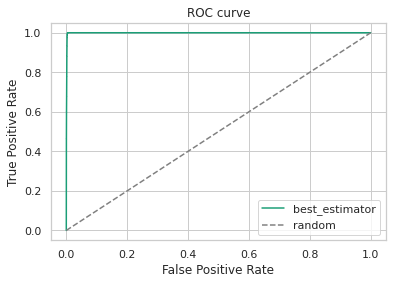

In [ ]:
probas = model.predict_proba(train_set.to_numpy())
func_roc_auc(proba=probas, y=y_train.to_numpy())

In [ ]:
probas = model.predict_proba(test_set.to_numpy())[:, 1]

In [ ]:
save_submission(probas, number=6)

In [ ]:
model = CatBoostClassifier(learning_rate=0.03, depth=11, l2_leaf_reg=3, iterations=200, 
                           auto_class_weights = "Balanced", loss_function = "Logloss", 
                           random_state=42)

In [ ]:
%%time
# Обучаем estimator
model.fit(train_resampled, y_train_resampled)

0:	learn: 0.6505223	total: 2.06s	remaining: 6m 49s
1:	learn: 0.6101733	total: 3.66s	remaining: 6m 2s
2:	learn: 0.5716811	total: 5.26s	remaining: 5m 45s
3:	learn: 0.5376098	total: 6.84s	remaining: 5m 35s
4:	learn: 0.5061575	total: 8.4s	remaining: 5m 27s
5:	learn: 0.4784843	total: 9.96s	remaining: 5m 22s
6:	learn: 0.4526946	total: 11.6s	remaining: 5m 19s
7:	learn: 0.4292197	total: 13.1s	remaining: 5m 15s
8:	learn: 0.4076690	total: 14.7s	remaining: 5m 12s
9:	learn: 0.3874033	total: 16.3s	remaining: 5m 10s
10:	learn: 0.3692379	total: 17.9s	remaining: 5m 7s
11:	learn: 0.3530049	total: 19.5s	remaining: 5m 5s
12:	learn: 0.3370354	total: 21s	remaining: 5m 2s
13:	learn: 0.3220342	total: 22.6s	remaining: 4m 59s
14:	learn: 0.3087728	total: 24.1s	remaining: 4m 57s
15:	learn: 0.2941539	total: 25.6s	remaining: 4m 54s
16:	learn: 0.2840717	total: 27.2s	remaining: 4m 52s
17:	learn: 0.2730853	total: 28.7s	remaining: 4m 50s
18:	learn: 0.2626414	total: 30.3s	remaining: 4m 49s
19:	learn: 0.2537964	total: 3

Лучшее качество auc_best_estimator: 1.0


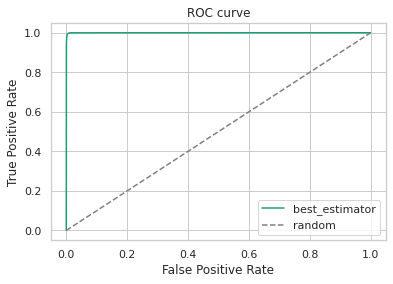

In [ ]:
probas = model.predict_proba(train_resampled)
func_roc_auc(proba=probas, y=y_train_resampled)

In [ ]:
probas = model.predict_proba(test_set.to_numpy())[:, 1]

In [ ]:
save_submission(probas, number=7)